In [53]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import pandas as pd
import numpy as np
df = pd.read_csv("cookie_cats.csv")
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [3]:
df.groupby("version").count()

,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,44700,44700,44700,44700
gate_40,45489,45489,45489,45489


,userid,sum_gamerounds
count,4.470000e+04,44700.000000
mean,4.987564e+06,52.456264
std,2.881026e+06,256.716423
min,1.160000e+02,0.000000
25%,2.505469e+06,5.000000
50%,4.983631e+06,17.000000
75%,7.481497e+06,50.000000
max,9.999710e+06,49854.000000


,userid,sum_gamerounds
count,4.548900e+04,45489.000000
mean,5.009073e+06,51.298776
std,2.885496e+06,103.294416
min,3.770000e+02,0.000000
25%,2.517171e+06,5.000000
50%,5.007329e+06,16.000000
75%,7.510762e+06,52.000000
max,9.999861e+06,2640.000000


<AxesSubplot:xlabel='version', ylabel='sum_gamerounds'>

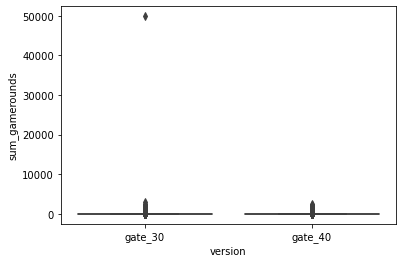

In [67]:
df[df["version"]=="gate_30"].describe()
df[df["version"]=="gate_40"].describe()

import seaborn as sns
#plot = sns.countplot(x="sum_gamerounds", hue="version", data=df)

sns.boxplot(x='version',y='sum_gamerounds',data=df)

<AxesSubplot:xlabel='version', ylabel='sum_gamerounds'>

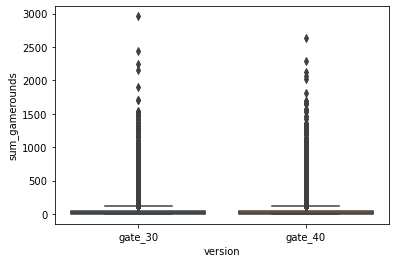

In [23]:
# drop max and plot
group_30 = df.loc[(df['sum_gamerounds'] != df['sum_gamerounds'].max()) & (df["version"]=="gate_30")]
group_40 = df.loc[(df['sum_gamerounds'] != df['sum_gamerounds'].max()) & (df["version"]=="gate_40")]
df_nomax = pd.concat([group_30, group_40])
sns.boxplot(x='version',y='sum_gamerounds',data=df_nomax)

userid        
version        gate_30 gate_40
sum_gamerounds                
0               1937.0  2057.0
1               2749.0  2789.0
2               2198.0  2408.0
3               1899.0  2059.0
4               1831.0  1798.0
...                ...     ...
2294               NaN     1.0
2438               1.0     NaN
2640               NaN     1.0
2961               1.0     NaN
49854              1.0     NaN

[942 rows x 2 columns]

<AxesSubplot:xlabel='sum_gamerounds'>

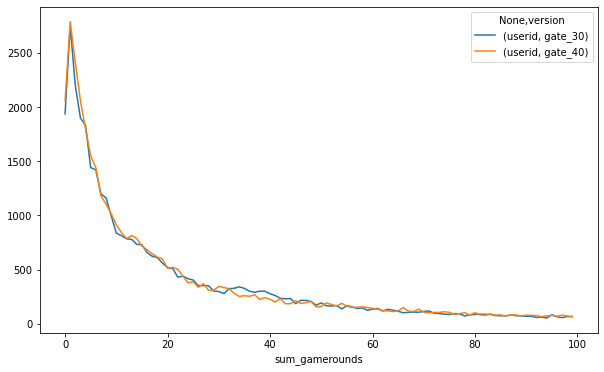

In [48]:
# Counting the number of players for each number of gamerounds 
plot_df = df.groupby(['sum_gamerounds','version'])['userid'].count()
plot_df = plot_df.to_frame()
plot_df = plot_df.unstack()
plot_df
plot_df[:100].plot(figsize=(10,6))

In [63]:
# comparing 1-day retention
df['retention_1'].mean()
df.groupby('version')['retention_1'].mean()
# comparing 7-day retention
df['retention_7'].mean()
df.groupby('version')['retention_7'].mean()

0.4452095044850259

version
gate_30    0.448188
gate_40    0.442283
Name: retention_1, dtype: float64

0.1860648194347426

version
gate_30    0.190201
gate_40    0.182000
Name: retention_7, dtype: float64

In [54]:
# A/B Testing Function - Quick Solution
def AB_Test(dataframe, group, target):
    
    # Packages
    from scipy.stats import shapiro
    import scipy.stats as stats
    
    # Split A/B
    groupA = dataframe[dataframe[group] == "gate_30"][target]
    groupB = dataframe[dataframe[group] == "gate_40"][target]
    
    # Assumption: Normality
    ntA = shapiro(groupA)[1] < 0.05
    ntB = shapiro(groupB)[1] < 0.05
    # H0: Distribution is Normal! - False
    # H1: Distribution is not Normal! - True
    
    if (ntA == False) & (ntB == False): # "H0: Normal Distribution"
        # Parametric Test
        # Assumption: Homogeneity of variances
        leveneTest = stats.levene(groupA, groupB)[1] < 0.05
        # H0: Homogeneity: False
        # H1: Heterogeneous: True
        
        if leveneTest == False:
            # Homogeneity
            ttest = stats.ttest_ind(groupA, groupB, equal_var=True)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
        else:
            # Heterogeneous
            ttest = stats.ttest_ind(groupA, groupB, equal_var=False)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
    else:
        # Non-Parametric Test
        ttest = stats.mannwhitneyu(groupA, groupB)[1] 
        # H0: M1 == M2 - False
        # H1: M1 != M2 - True
        
    # Result
    temp = pd.DataFrame({
        "AB Hypothesis":[ttest < 0.05], 
        "p-value":[ttest]
    })
    temp["Test Type"] = np.where((ntA == False) & (ntB == False), "Parametric", "Non-Parametric")
    temp["AB Hypothesis"] = np.where(temp["AB Hypothesis"] == False, "Fail to Reject H0", "Reject H0")
    temp["Comment"] = np.where(temp["AB Hypothesis"] == "Fail to Reject H0", "A/B groups are similar!", "A/B groups are not similar!")
    
    # Columns
    if (ntA == False) & (ntB == False):
        temp["Homogeneity"] = np.where(leveneTest == False, "Yes", "No")
        temp = temp[["Test Type", "Homogeneity","AB Hypothesis", "p-value", "Comment"]]
    else:
        temp = temp[["Test Type","AB Hypothesis", "p-value", "Comment"]]
    
    # Print Hypothesis
    print("# A/B Testing Hypothesis")
    print("H0: A == B")
    print("H1: A != B", "\n")
    
    return temp
    
    
    
# Apply A/B Testing
AB_Test(dataframe=df, group = "version", target = "sum_gamerounds")

# A/B Testing Hypothesis
H0: A == B
H1: A != B 



C:\Users\92350\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,Test Type,AB Hypothesis,p-value,Comment
0,Non-Parametric,Reject H0,0.025104,A/B groups are not similar!


In [65]:
from scipy.stats import shapiro
import scipy.stats as stats
groupA = df[df["version"] == "gate_30"]["sum_gamerounds"]
shapiro(groupA)[1]
groupB = df[df["version"] == "gate_40"]["sum_gamerounds"]
shapiro(groupB)[1]

# one side test
stats.mannwhitneyu(groupA, groupB, alternative = 'greater')

0.0

0.0

MannwhitneyuResult(statistic=1024331250.5, pvalue=0.025104403860221253)

### Boostrap

<AxesSubplot:ylabel='Density'>

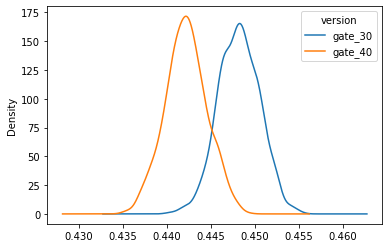

In [58]:
# Creating an list with bootstrapped means for each AB-group
boot_1d = []
for i in range(1000):
    boot_mean = df.sample(frac = 1,replace = True).groupby('version')['retention_1'].mean()
    boot_1d.append(boot_mean)
    
# Transforming the list to a DataFrame
boot_1d = pd.DataFrame(boot_1d)
    
# A Kernel Density Estimate plot of the bootstrap distributions
boot_1d.plot(kind='density')

Text(0.5, 1.0, '% difference in 1-day retention between the two groups')

Probability that 1-day retention is greater when the gate is at level 30: 0.97


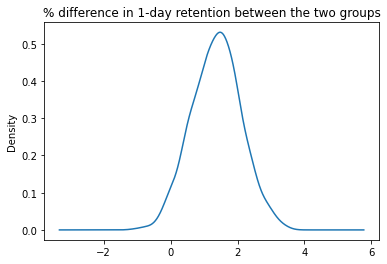

In [68]:
# Adding a column with the % difference between the two AB-groups
boot_1d['diff'] = (boot_1d.gate_30 - boot_1d.gate_40)/boot_1d.gate_40*100

# Ploting the bootstrap % difference
ax = boot_1d['diff'].plot(kind='density')
ax.set_title('% difference in 1-day retention between the two groups')

# Calculating the probability that 1-day retention is greater when the gate is at level 30
print('Probability that 1-day retention is greater when the gate is at level 30:',(boot_1d['diff'] > 0).mean())

<AxesSubplot:ylabel='Density'>

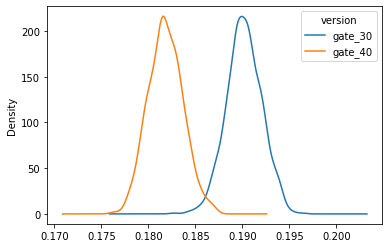

In [61]:
# Creating an list with bootstrapped means for each AB-group
boot_7d = []
for i in range(1000):
    boot_mean = df.sample(frac = 1,replace = True).groupby('version')['retention_7'].mean()
    boot_7d.append(boot_mean)
    
# Transforming the list to a DataFrame
boot_7d = pd.DataFrame(boot_7d)
    
# A Kernel Density Estimate plot of the bootstrap distributions
boot_7d.plot(kind='density')

Text(0.5, 1.0, '% difference in 7-day retention between the two groups')

Probability that 7-day retention is greater when the gate is at level 30: 1.0


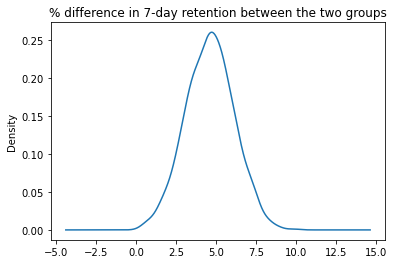

In [69]:
# Adding a column with the % difference between the two AB-groups
boot_7d['diff'] = (boot_7d.gate_30 - boot_7d.gate_40)/boot_7d.gate_40*100

# Ploting the bootstrap % difference
ax = boot_7d['diff'].plot(kind='density')
ax.set_title('% difference in 7-day retention between the two groups')

# Calculating the probability that 7-day retention is greater when the gate is at level 30
print('Probability that 7-day retention is greater when the gate is at level 30:',(boot_7d['diff'] > 0).mean())